# SETUP

In [9]:
import os
import json
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors

import pickle
#plt.rcParams.update({'font.size': 16})
#plt.show() # need to call show so will update default params above
# color blind friendly colors
# https://gist.github.com/thriveth/8560036
tableau_colors = mcolors.TABLEAU_COLORS
color_dict = {name.split(':')[1]:tableau_colors[name] for name in tableau_colors}
color_list = [color_dict[name] for name in color_dict]
def get_color(idx):
    return color_list[idx%len(color_list)]
markers = [
    '.',
    'x',
    '+',
    '*',
    '1',
    '^',
    's',
    'd',
    'H',
    '3',
    'o',
]
import sys
dropbox_path = '/home/tim/Dropbox/'
sys.path.append(dropbox_path)
models_path = f'{dropbox_path}models/'

In [10]:
# base map
case_map = {
    'a':{
        'color':color_dict['blue'],
        'marker':markers[0],
    },
    'b':{
        'color':color_dict['orange'],
        'marker':markers[1],
    },
    'c':{
        'color':color_dict['green'],
        'marker':markers[2],
    },
    'd':{
        'color':color_dict['red'],
        'marker':markers[3],
    },
    'e':{
        'color':color_dict['purple'],
        'marker':markers[4],
    },
    'f':{
        'color':color_dict['brown'],
        'marker':markers[5],
    },
    'g':{
        'color':color_dict['pink'],
        'marker':markers[6],
    },
    'h':{
        'color':color_dict['gray'],
        'marker':markers[7],
    },
    'i':{
        'color':color_dict['olive'],
        'marker':markers[8],
    },
    'j':{
        'color':color_dict['cyan'],
        'marker':markers[9],
    },
    'k':{
        'color':color_dict['blue'],
        'marker':markers[10],
    },
}

In [11]:
# DQN_v2
case_map['a']['label'], case_map['a']['val'] = 'control', 0
case_map['b']['label'], case_map['b']['val'] = r'$X = 2$', 2
case_map['c']['label'], case_map['c']['val'] = r'$X = 4$', 4
case_map['d']['label'], case_map['d']['val'] = r'$X = 6$', 6
case_map['e']['label'], case_map['e']['val'] = r'$X = 8$', 8
case_map['f']['label'], case_map['f']['val'] = r'$X = 10$', 10
case_map['g']['label'], case_map['g']['val'] = r'$X = 12$', 12
case_map['h']['label'], case_map['h']['val'] = r'$X = 14$', 14
case_map['i']['label'], case_map['i']['val'] = r'$X = 16$', 16
case_map['j']['label'], case_map['j']['val'] = r'$X= 18$', 18
case_map['k']['label'], case_map['k']['val'] = r'$X= 20$', 20

airsim_map = 'AirSimNH'
motion = '2d'
project_name = 'navigation'
experiment_name = 'DQN_v0'
fetch_cases = list(case_map.keys())
fetch_xlabels = [str(2*delta_x) for delta_x in range(10)]
Xlabel = r'$X$ [meters]'
fetch_version = 'v0'

/home/tim/Dropbox/models/navigation/DQN_v0/AirSimNH_2d_v0_a/ 3
/home/tim/Dropbox/models/navigation/DQN_v0/AirSimNH_2d_v0_a/ 0
/home/tim/Dropbox/models/navigation/DQN_v0/AirSimNH_2d_v0_a/ 9
/home/tim/Dropbox/models/navigation/DQN_v0/AirSimNH_2d_v0_a/ 7
/home/tim/Dropbox/models/navigation/DQN_v0/AirSimNH_2d_v0_a/ 2
/home/tim/Dropbox/models/navigation/DQN_v0/AirSimNH_2d_v0_a/ .ipynb_checkpoints
/home/tim/Dropbox/models/navigation/DQN_v0/AirSimNH_2d_v0_a/ 1
/home/tim/Dropbox/models/navigation/DQN_v0/AirSimNH_2d_v0_a/ 4
/home/tim/Dropbox/models/navigation/DQN_v0/AirSimNH_2d_v0_a/ 8
/home/tim/Dropbox/models/navigation/DQN_v0/AirSimNH_2d_v0_a/ 5
/home/tim/Dropbox/models/navigation/DQN_v0/AirSimNH_2d_v0_a/ 6


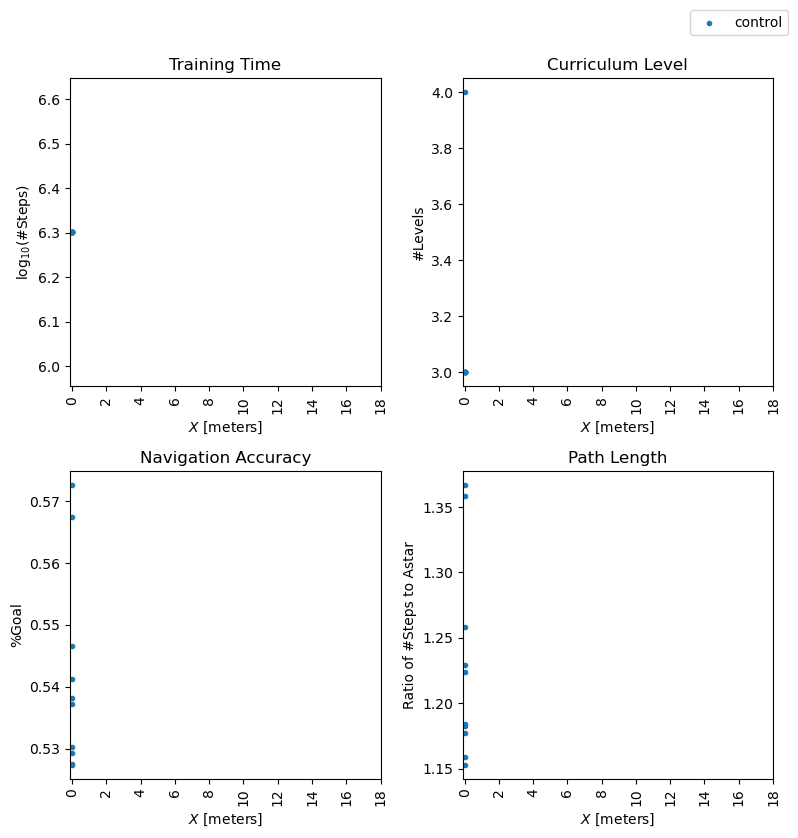

In [14]:
episodes = []
steps = []
test_accuracys = []
test_lengths = []
levels = []
Xs = []
runs = []
labels = []
colors = []
cases = []
markers = []
best_runs = {}
for vi, version in enumerate([fetch_version]):
    these_runs = []
    for case in fetch_cases:
        trial_name = f'{airsim_map}_{motion}_{version}_{case}'
        runs_folder = models_path + '/'.join([project_name, experiment_name, trial_name])+'/'
        if os.path.exists(runs_folder):
            run_names = os.listdir(runs_folder)
            for run_name in run_names:
                print(runs_folder, run_name)
                if '.' in run_name:
                    continue
                run_num = int(run_name)
                working_directory = runs_folder + run_name + '/'
                
                configuration_path = working_directory + 'configuration.json'
                if not os.path.exists(configuration_path):
                   continue
                configuration = json.load(open(configuration_path, 'r'))
                nEpisodes = configuration['components']['Environment']['episode_counter']
                nSteps = configuration['components']['Environment']['step_counter']
                level = configuration['components']['Curriculum']['level']
                
                results_path = working_directory + 'test_final/evaluation.json'
                if not os.path.exists(results_path):
                    continue
                results = json.load(open(results_path, 'r'))
                #level = results['level'] + 1
                #nEpisodes = results['episodes']
                #nSteps = results['steps']
                test_accuracy = np.mean(results['successes'])
                test_length = np.mean(results['lengths'])

                # evaluation_path = working_directory + 'test_final/evaluation.json'
                # if os.path.exists(evaluation_path):
                #     evaluation = json.load(open(evaluation_path, 'r'))
                #     test_accuracy = 100*np.mean(evaluation['successes'])
                #     test_length = np.mean(evaluation['lengths'])

                if case not in best_runs:
                    best_runs[case] = [run_name, test_accuracy]
                if test_accuracy > best_runs[case][1]:
                    best_runs[case] = [run_name, test_accuracy]

                color, marker, label, val = case_map[case]['color'], case_map[case]['marker'], case_map[case]['label'], case_map[case]['val']
                case_idx = fetch_cases.index(case)
                
                steps.append(nSteps)
                cases.append(case)
                labels.append(label)
                markers.append(marker)
                episodes.append(nEpisodes)
                test_accuracys.append(test_accuracy)
                test_lengths.append(test_length)
                Xs.append(case_idx)
                colors.append(color)
                these_runs.append(run_name)
                levels.append(level)
    runs.append(these_runs)
        
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

ax = axs[0,0]
time_stats = {case:[] for case in case_map}
ax.set_title('Training Time')
for i in range(len(Xs)):
    time_stats[cases[i]].append(steps[i])
    ax.scatter(Xs[i], np.log10(steps[i]), color=colors[i], marker=markers[i])
ax.set_xticks([i for i in range(len(fetch_xlabels))], [xlabel for xlabel in fetch_xlabels], rotation=90)
ax.set_xlabel(Xlabel)
ax.set_ylabel('log$_{10}$(#Steps)')

ax = axs[0,1]
level_stats = {case:[] for case in case_map}
ax.set_title('Curriculum Level')
cased = {}
for i in range(len(Xs)):
    level_stats[cases[i]].append(levels[i])
    if cases[i] not in cased:
        ax.scatter(Xs[i], levels[i], color=colors[i], marker=markers[i], label=labels[i])
        cased[cases[i]] = True
    else:
        ax.scatter(Xs[i], levels[i], color=colors[i], marker=markers[i])
ax.set_xticks([i for i in range(len(fetch_xlabels))], [xlabel for xlabel in fetch_xlabels], rotation=90)
ax.set_xlabel(Xlabel)
ax.set_ylabel('#Levels')
#ax.legend(loc='center left', fancybox=True, bbox_to_anchor=(-1, 1.4), ncols=3)
fig.legend(bbox_to_anchor=(1, 1.05), ncols=len(cased))   

ax = axs[1,0]
acc_stats = {case:[] for case in case_map}
ax.set_title('Navigation Accuracy')
for i in range(len(Xs)):
    acc_stats[cases[i]].append(test_accuracys[i])
    ax.scatter(Xs[i], test_accuracys[i], color=colors[i], marker=markers[i])
ax.set_xticks([i for i in range(len(fetch_xlabels))], [xlabel for xlabel in fetch_xlabels], rotation=90)
ax.set_xlabel(Xlabel)
ax.set_ylabel('%Goal')
    
ax = axs[1,1]
length_stats = {case:[] for case in case_map}
ax.set_title('Path Length')
for i in range(len(Xs)):
    length_stats[cases[i]].append(test_lengths[i])
    ax.scatter(Xs[i], test_lengths[i], color=colors[i], marker=markers[i])
ax.set_xticks([i for i in range(len(fetch_xlabels))], [xlabel for xlabel in fetch_xlabels], rotation=90)
ax.set_xlabel(Xlabel)
ax.set_ylabel('Ratio of #Steps to Astar')

#plt.suptitle(f'same color = same random run')
plt.tight_layout()
plt.show()

In [ ]:
# read states
# json files output with all string key names
# process so that the evaluation dictionary structure is such:
    # episode # - int
        # step # - int
            # state - dictionary of misc key, value pairs for that state
def process_episodes(json_evaluation):
    nEpisodes = len(json_evaluation)
    episodes = [None] * nEpisodes
    episode_idx = 0
    for episode_str in json_evaluation:
        if 'episode_' not in episode_str:
            continue
        json_episode = json_evaluation[episode_str]
        nSteps = len(json_episode)
        states = [None] * nSteps
        for step_str in json_episode:
            step_num = int(step_str.split('_')[1])
            state = json_episode[step_str]
            states[step_num] = state
        episodes[episode_idx] = states
        episode_idx += 1
    return episodes
def read_evaluations(evaluation_folder):
    evaluation_files = [file for file in os.listdir(evaluation_folder) if 'states' in file]
    nEvaluations = len(evaluation_files)
    evaluations = [None] * nEvaluations
    for evaluation_file in evaluation_files:
        if '.json' not in evaluation_file:
            continue
        epoch = int(evaluation_file.split('.')[0].split('_')[-1])
        #print(evaluation_file, epoch)
        json_evaluation = json.load(open(evaluation_folder + evaluation_file, 'r'))
        episodes = process_episodes(json_evaluation)
        evaluations[epoch] = episodes
    return evaluations
# architecture for evaluations:
# evaluations - list of episodes (indexed of evaluation number) - 0 idx is first evaluation
    # episodes - list of states (indexed by step number)
        # states - dict of (key, value) pairs for state at all_evaluations[instance][evaluation][episode][step]
# read evaluations from each instance
# each instance is a sub folder from parent with which this eval notebook is in

# get all raw data results dicts

In [ ]:
# params
version = fetch_version

# results dicts
Inits = [] # global
Xs = {} # case by case
Accuracies = {} # case by case
Terminations = {case:[] for case in best_runs} # path by path
Madps = {case:[] for case in best_runs} # step by step

# collect
for case in best_runs:
    run_name = best_runs[case][0]
    trial_name = f'{airsim_map}_{motion}_{version}_{case}'
    runs_folder = models_path + '/'.join([project_name, experiment_name, trial_name])+'/'
    run_num = int(run_name)
    working_directory = runs_folder + run_name + '/'

    # case by case results
    Xs[case] = case_map[case]['val']
    Accuracies[case] = best_runs[case][1]

    # iterate through each episode
    states_path = f'{working_directory}test_final/states/'
    episodes = read_evaluations(states_path)[0]
    for episode_idx, episode in enumerate(episodes):
        # path by path
        init_state = episode[0]
        if case == 'a':
            Inits.append(init_state)
        final_state = episode[-1]
        Terminations[case].append(final_state['termination_reason'])
        madps = []
        madps.append(False)
        for state in episode[1:-1]:
            if case == 'a':
                madps.append(False)
            else:
                madps.append(state['use_madp'])
        Madps[case].append(madps)

pickle.dump( {
    'Xs':Xs,
    'Inits':Inits,
    'Accuracies':Accuracies,
    'Madps':Madps,
    'Terminations':Terminations,
}, open(f'bank/figures/data/navi_results_{experiment_name}.p', 'wb'))
          #  open(f'G:\My Drive\projects\Project SmartDepth\SmartDepth_shared\figures\data\navi_results_{version}.p', 'wb'))

# get all other metrics from each frame wrt to goals_rel

In [ ]:
version = fetch_version
for case in best_runs:
    run_name = best_runs[case][0]
    trial_name = f'{airsim_map}_{motion}_{version}_{case}'
    runs_folder = models_path + '/'.join([project_name, experiment_name, trial_name])+'/'
    run_num = int(run_name)
    working_directory = runs_folder + run_name + '/'

    states_path = f'{working_directory}test_final/states/'
    episodes = read_evaluations(states_path)[0]
    for episode_idx, episode in enumerate(episodes):
        energies = power_dnn * time_dnn
        _time = time_dnn
        _powers = [power_dnn]
        init_state = episode[0]
        final_state = episode[-1]
        nSteps = len(episode)
        Steps[case][episode_idx] = nSteps
        for state in episode[1:-1]:
            use_madp = False
            if 'use_madp' in state:
                use_madp = state['use_madp']
            if use_madp:
                _powers.append(power_madp)
                _energy += power_madp * time_madp
                _time += time_madp
            else:
                _powers.append(power_dnn)
                _energy += power_dnn * time_dnn
                _time += time_dnn
        Powers[case][episode_idx] = np.mean(_powers)
        Energies[case][episode_idx] = _energy
        Times[case][episode_idx] =_time

In [ ]:
pickle.dump({
    'X':Xs,
    'matches':matches,
    'accuracy':Accs,
    'length':Steps,
    'time':Times,
    'energy':Energies,
    'power':Powers,
}, open('navi_results.p', 'wb'))

In [ ]:
version = fetch_version
power_dnn = 23.88
power_madp = 10.34
time_dnn = 0.3882
time_madp = 0.0103 
Steps = {}
Energies = {}
Times = {}
Powers = {}
for case in best_runs:
    run_name = best_runs[case][0]
    trial_name = f'{airsim_map}_{motion}_{version}_{case}'
    runs_folder = models_path + '/'.join([project_name, experiment_name, trial_name])+'/'
    run_num = int(run_name)
    working_directory = runs_folder + run_name + '/'
    
    results_path = working_directory + 'results.json'
    results = json.load(open(results_path, 'r'))
    level = results['level'] + 1
    nEpisodes = results['episodes']
    nSteps = results['steps']
    test_accuracy = results['test_accuracy']
    test_length = results['test_length']

    states_path = f'{working_directory}test_final/states/'
    episodes = read_evaluations(states_path)[0]

    Steps[case] = {}
    Energies[case] = {}
    Times[case] = {}
    Powers[case] = {}
    test_idxs = matches['a']
    for episode_idx, episode in enumerate(episodes):
        if episode_idx not in test_idxs:
            continue
        _energy = power_dnn * time_dnn
        _time = time_dnn
        _powers = [power_dnn]
        init_state = episode[0]
        final_state = episode[-1]
        nSteps = len(episode)
        Steps[case][episode_idx] = nSteps
        for state in episode[1:-1]:
            use_madp = False
            if 'use_madp' in state:
                use_madp = state['use_madp']
            if use_madp:
                _powers.append(power_madp)
                _energy += power_madp * time_madp
                _time += time_madp
            else:
                _powers.append(power_dnn)
                _energy += power_dnn * time_dnn
                _time += time_dnn
        Powers[case][episode_idx] = np.mean(_powers)
        Energies[case][episode_idx] = _energy
        Times[case][episode_idx] =_time

In [ ]:
pickle.dump({
    'X':Xs,
    'matches':matches,
    'accuracy':Accs,
    'length':Steps,
    'time':Times,
    'energy':Energies,
    'power':Powers,
}, open('navi_results2.p', 'wb'))

In [ ]:
version = fetch_version
power_dnn = 23.88
power_madp = 10.34
time_dnn = 0.3882
time_madp = 0.0103 
Steps = {}
Energies = {}
Times = {}
Powers = {}
for case in best_runs:
    run_name = best_runs[case][0]
    trial_name = f'{airsim_map}_{motion}_{version}_{case}'
    runs_folder = models_path + '/'.join([project_name, experiment_name, trial_name])+'/'
    run_num = int(run_name)
    working_directory = runs_folder + run_name + '/'
    
    results_path = working_directory + 'results.json'
    results = json.load(open(results_path, 'r'))
    level = results['level'] + 1
    nEpisodes = results['episodes']
    nSteps = results['steps']
    test_accuracy = results['test_accuracy']
    test_length = results['test_length']

    states_path = f'{working_directory}test_final/states/'
    episodes = read_evaluations(states_path)[0]

    Steps[case] = {}
    Energies[case] = {}
    Times[case] = {}
    Powers[case] = {}
    test_idxs = matches['a']
    for episode_idx, episode in enumerate(episodes):
        if episode_idx not in test_idxs:
            continue
        _energy = power_dnn * time_dnn
        _time = time_dnn
        _powers = [power_dnn]
        init_state = episode[0]
        final_state = episode[-1]
        nSteps = len(episode)
        Steps[case][episode_idx] = nSteps
        for state in episode[1:-1]:
            use_madp = False
            if 'use_madp' in state:
                use_madp = state['use_madp']
            if use_madp:
                _powers.append(power_madp)
                _energy += power_madp * time_madp
                _time += time_madp
            else:
                _powers.append(power_dnn)
                _energy += power_dnn * time_dnn
                _time += time_dnn
        Powers[case][episode_idx] = _powers
        Energies[case][episode_idx] = _energy
        Times[case][episode_idx] =_time

In [ ]:
pickle.dump({
    'X':Xs,
    'matches':matches,
    'accuracy':Accs,
    'length':Steps,
    'time':Times,
    'energy':Energies,
    'power':Powers,
}, open('navi_results2.p', 'wb'))

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
fig.suptitle('Histograms over all runs')

ax = axs[0,0]
for case in time_stats:
    ax.hist(time_stats[case], label=case_map[case]['label'], alpha = 0.5, color=case_map[case]['color'])
    ax.set_xlabel('# of Training Episodes')
    ax.set_ylabel('bin count')
    #ax.set_title('Histogram over all runs')
    ax.legend()

ax = axs[0,1]
for case in level_stats:
    ax.hist(level_stats[case], label=case_map[case]['label'], alpha = 0.5, color=case_map[case]['color'])
    ax.set_xlabel('Highest Reached Curriculum Level')
    ax.set_ylabel('bin count')
    #ax.set_title('Histogram over all runs')
    #ax.legend()

ax = axs[1,0]
for case in acc_stats:
    ax.hist(acc_stats[case], label=case_map[case]['label'], alpha = 0.5, color=case_map[case]['color'])
    ax.set_xlabel('% Navigation Accuracy')
    ax.set_ylabel('bin count')
    #ax.set_title('Histogram over all runs')
    #ax.legend()

ax = axs[1,1]
for case in length_stats:
    ax.hist(length_stats[case], label=case_map[case]['label'], alpha = 0.5, color=case_map[case]['color'])
    ax.set_xlabel('Path Length = *Astar Truth')
    ax.set_ylabel('bin count')
    #ax.set_title('Histogram over all runs')
    #ax.legend()

plt.tight_layout()
plt.show()